In [67]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [41]:
# setting up a test
%cd '/home/kele/Documents/lai/test'
%pwd
!cp /home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/S99/A33/AFT99/plink_map.txt .
!cp /home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/S99/A33/AFT99/sample_map.txt .
!cp /home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/S99/A33/AFT99/phased.target_inds.vcf.gz.csi .
!cp /home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/S99/A33/AFT99/phased.target_inds.vcf.gz .
!cp /home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/S99/A33/AFT99/phased.reference_inds.vcf.gz.csi .
!cp /home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/S99/A33/AFT99/phased.reference_inds.vcf.gz .
!cp /home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/S99/A33/AFT99/site.positions .


BMIX = '/home/kele/Documents/lai/lai-sim/programs/bmix/bmix.jar'
reference_vcf = './phased.reference_inds.vcf.gz'
target_vcf = './phased.target_inds.vcf.gz'
sample_map = './sample_map.txt'
plink_map = './plink_map.txt'
prefix = 'bmix'
seed = '1234'
nthreads = '4'
BCFTOOLS = '/home/kele/Documents/lai/lai-sim/programs/bcftools/bcftools-1.14/bcftools'

/home/kele/Documents/lai/test


In [31]:
to_run = (f"java -Xmx30g -jar {BMIX} "
f"ref={reference_vcf} "
f"ref-panel={sample_map} "
f"gt={target_vcf} "
f"map={plink_map} "
f"out={prefix} "
f"probs=true "
f"nthreads={nthreads} "
f"seed={seed} "
f"min-maf=0.05 ")
print(to_run)
!{to_run}
!{BCFTOOLS} index {prefix}.anc.vcf.gz

java -Xmx30g -jar /home/kele/Documents/lai/lai-sim/programs/bmix/bmix.jar ref=./phased.reference_inds.vcf.gz ref-panel=./sample_map.txt gt=./phased.target_inds.vcf.gz map=./plink_map.txt out=bmix probs=true nthreads=4 seed=1234 min-maf=0.05 
Copyright (C) 2021 Brian L. Browning
Enter "java -jar bmix.jar" to print a list of command line arguments

Program             :  bmix.jar  [ version 0.1, 02Nov21.5b3 ]
Start Time          :  10:59 AM PST on 19 Jan 2022
Max Memory          :  30720 MB

Parameters
  ref               :  ./phased.reference_inds.vcf.gz
  ref-panel         :  ./sample_map.txt
  gt                :  ./phased.target_inds.vcf.gz
  map               :  ./plink_map.txt
  out               :  bmix
  min-maf           :  0.05
  probs             :  true
  gen               :  10.0
  em                :  true
  nthreads          :  4
  seed              :  1234

Statistics
  reference samples :  60
  target samples    :  10
  markers           :  9354

Wallclock Time      :  2

In [35]:
# extract the sites present in the bmix output 
!{BCFTOOLS} query -f '%POS\n' {prefix}.anc.vcf.gz > ./bmix.sites

In [36]:
def load_bmix(path):
	csv_path = path.replace('.vcf.gz', '.csv')
	# conver the vcf.gz to a csv
	os.system(f"{BCFTOOLS} query -f '%CHROM, %POS, [%ANP1, %ANP2,]\\n' {path} > {csv_path}")
	bmix = pd.read_csv(csv_path, header=None)
	bmix = bmix.dropna(axis=1)
	return(bmix.iloc[:,2:].values)

In [211]:
res = load_bmix(f"{prefix}.anc.vcf.gz")
res.shape

(9354, 60)

In [212]:
res

array([[0.  , 1.  , 0.  , ..., 1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , ..., 1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , ..., 1.  , 0.  , 0.  ],
       ...,
       [1.  , 0.  , 0.  , ..., 0.  , 0.73, 0.27],
       [1.  , 0.  , 0.  , ..., 0.  , 0.73, 0.27],
       [1.  , 0.  , 0.  , ..., 0.  , 0.73, 0.27]])

In [213]:
res2 = res.copy()

## Modifies the res array in place.  
Replaces each probabalistic call with a categorical call for the ancestry with the higher posterior probability. 
Breaks ties by going to the lower number population

In [216]:
nanc=3
idxs = np.arange(0, res.shape[1]+nanc, nanc)
for i in range(1, len(idxs)):
    b = res[:, idxs[i-1]:idxs[i]]
    a = b.argmax(1, keepdims=True) # breaks ties by assigning the lower pop
    c = np.zeros_like(b)
    np.put_along_axis(c, a, 1, axis = 1)
    res[:, idxs[i-1]:idxs[i]] = c

In [ ]:
def 

In [205]:
np.array([1,2,2,3,3,2]).argmax()

3

In [202]:
np.allclose(res, res2)

False

In [203]:
np.allclose(b, res2[:, 0:3])

False

In [217]:
def max_la(vals, nanc):
    idxs = np.arange(0, vals.shape[1]+nanc, nanc)
    for i in range(1, len(idxs)):
        b = vals[:, idxs[i-1]:idxs[i]]
        a = b.argmax(1, keepdims=True) # breaks ties by assigning the lower pop
        c = np.zeros_like(b)
        np.put_along_axis(c, a, 1, axis = 1)
        vals[:, idxs[i-1]:idxs[i]] = c
    return(vals)
max_la(vals=res, nanc=3)

array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [159]:
b = np.zeros_like(res[:, idxs[i-1]:idxs[i]])
b.shape

(9906, 3)

In [160]:
b[a.reshape(-1, 1)].shape

(9906, 1, 3)

In [161]:
np.put_along_axis(b, a.reshape(-1, 1), 1, axis = 1)

In [162]:
b

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [114]:
np.zeros_like(res, dtype='float16')


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

In [40]:
# how do we expand this to the non-present sites?

In [89]:
!{BCFTOOLS} query -f '%POS\n' {prefix}.anc.vcf.gz > ./bmix.sites
res = load_bmix(f"{prefix}.anc.vcf.gz")
pre_sites = pd.read_csv('./site.positions', header=None).values.flatten()
post_sites = pd.read_csv('./bmix.sites', header=None).values.flatten()
post_indexes = np.searchsorted(post_sites, pre_sites)
res = res[post_indexes]
res.shape

(9906, 60)

In [61]:
pre_sites

array([    4545,    10659,    10784, ..., 51291204, 51295506, 51303528])

In [62]:
post_sites

array([    4545,    10659,    10784, ..., 51291204, 51295506, 51303528])

In [72]:
## for each pre site, which post site value do I use.

In [81]:
post_indexes = np.searchsorted(post_sites, pre_sites)
len(post_indexes)

9906

In [88]:
res[post_indexes].shape

(9906, 60)

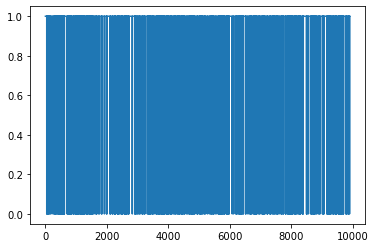

In [79]:
np.diff(np.searchsorted(post_sites, pre_sites)).sum()

In [97]:
nr = np.array([int(x) for x in "20,18,16".split(',')])

9354

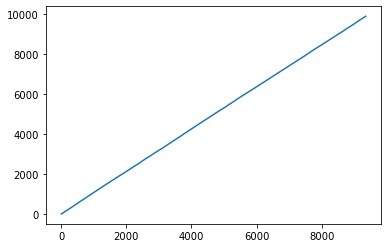

In [73]:
plt.plot(np.searchsorted(pre_sites, post_sites))
len(np.searchsorted(pre_sites, post_sites))

In [71]:
len(np.searchsorted(post_sites, pre_sites))

9906

In [75]:
np.diff(np.searchsorted(post_sites, pre_sites)).sum()

9353

In [58]:
for x in pre_sites:


4545
10659
10784
13134
17738
20867
31751
36073
62902
68215
68315
70013
79867
87632
91086
103843
108912
118826
119286
122976
125100
138179
139312
141353
144264
152089
152564
153780
157572
163977
170967
175093
176976
180573
192875
202145
207229
210212
218007
219056
219548
230898
235441
235767
240144
241695
242138
251817
254873
258865
265329
273502
289296
292477
297129
298854
304753
308906
309180
312445
318673
342662
348913
349820
352559
353255
354674
356728
373206
374364
375486
380940
383854
388731
392011
402893
410634
421399
423710
431900
436455
437526
439782
441659
444688
454057
462998
463544
480927
489990
495275
495362
498339
509706
510328
510623
518576
529588
531832
540723
541296
547460
561803
565611
566918
578667
580149
581430
585630
585842
588351
589868
605843
611978
615184
619675
620793
623944
630490
635164
635511
646358
649376
649873
655143
656906
659998
666602
667607
672046
672218
673557
675784
681541
684621
684733
687590
690303
696047
698218
702661
706243
708142
709181
715337
7

17969161
17973643
17975538
17978942
17985661
17996433
17999021
18006163
18009838
18011119
18018629
18023502
18024864
18025749
18027855
18031274
18037078
18038874
18049897
18051202
18055388
18057900
18062934
18063712
18066405
18071883
18080906
18081861
18085145
18085279
18088804
18092033
18094120
18102220
18102890
18104740
18107093
18116906
18117035
18124851
18125099
18132011
18135518
18137337
18144661
18145090
18159079
18159901
18168646
18173089
18184773
18186431
18188518
18192045
18198800
18202729
18207675
18214859
18217479
18219752
18223267
18228314
18230638
18231471
18237208
18238117
18247853
18256638
18257601
18287225
18298374
18304529
18305910
18326497
18329962
18330883
18334169
18336471
18340270
18340280
18340530
18347685
18348514
18348965
18351041
18359507
18375031
18381780
18392347
18393115
18394911
18398437
18404645
18410004
18420608
18422594
18423348
18423495
18429513
18433489
18443111
18446228
18448093
18448364
18452410
18462341
18472278
18475437
18477172
18491072
18500205
1

39294727
39297283
39308761
39310937
39311282
39311458
39333129
39338964
39338998
39339600
39342830
39343285
39344052
39369620
39374144
39383126
39383225
39392058
39393182
39403413
39412156
39412343
39424494
39428787
39434228
39435988
39441855
39444391
39445222
39445238
39446067
39453950
39456326
39459977
39461810
39462348
39465564
39473310
39476169
39478317
39480601
39482628
39484793
39485417
39486329
39487363
39491297
39495976
39501218
39510068
39512624
39514196
39514314
39514330
39522635
39525365
39530364
39531819
39532273
39532495
39533529
39538657
39540172
39541856
39542242
39548469
39552076
39558130
39566332
39571131
39576104
39585796
39601281
39622544
39624904
39627791
39628329
39630767
39634887
39635165
39635544
39635987
39637013
39646319
39646983
39652646
39653692
39659542
39667804
39676357
39683952
39684294
39694493
39694524
39700915
39704286
39704903
39705016
39707578
39717463
39719435
39720363
39726495
39729645
39732314
39735355
39745711
39747523
39764850
39786689
39789584
3

In [100]:
npops = 4
nind_ref = 10
nr = np.array([int(x) for x in "20,18,16".split(',')])
np.repeat(np.arange(1, npops), 2*nind_ref)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [102]:
np.bincount(np.repeat(np.arange(1, npops), 2*nr))

array([ 0, 40, 36, 32])

In [ ]:
"java -Xmx30g -jar {params.BMIX} "
"ref={input.reference_vcf} "
"ref-panel={input.sample_map} "
"gt={input.target_vcf} "
"map={input.genetic_map} "
"out={params.prefix} "
"probs=true "
"nthreads={params.nthreads} "
"seed={params.seed} "
#"min-maf=0 "

"""

{params.bcftools} index {params.prefix}.anc.vcf.gz
"""